In [3]:
# Import required packages
import numpy as np
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import scipy.optimize as optim
import copy
import random
import pickle
from IPython.display import Markdown, display
import seaborn as sns
import matplotlib.patches as patches
from tabulate import tabulate

## 1) Load the dataset

For this project we are using the COMPAS-scores-two-years dataset, a COMPAS dataset that contains the criminal history, jail and prison time, demographics, and COMPAS risk scores for defendants from Broward county from 2013 and 2014, as well as the ground truth on whether or not these individuals actually recidivated within two years after the screening.  

There are 7214 data in total.

In [4]:
raw_data = pd.read_csv('../data/compas-scores-two-years.csv')

In [5]:
raw_data

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


## 2) Data processing

### 2.1) Subset of data with race "African-American" or "Caucasian"

We want to keep only the rows of the dataset that correspond to "African-American" or "Caucasian" race.

In [6]:
print("The dataset includes defendants of the following races: {}".format(raw_data['race'].unique()))

The dataset includes defendants of the following races: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Native American'
 'Asian']


In [7]:
processed_data = raw_data.loc[raw_data['race'].isin(["African-American", "Caucasian"])]

In [8]:
print("The original dataset includes {} African-American and Caucasian defendants.".format(processed_data.shape[0]))

The original dataset includes 6150 African-American and Caucasian defendants.


In [9]:
processed_data

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,10994,jarred payne,jarred,payne,2014-05-10,Male,1985-07-31,30,25 - 45,African-American,...,2,Low,2014-05-10,2015-10-22,2015-10-22,0,0,529,1,1
7208,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,9,High,2013-10-20,2014-04-07,2014-04-27,0,0,169,0,0
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0


### 2.2) Remove unuseful data

Remove unuseful columns (columns with multiple missing data).

In [10]:
processed_data = processed_data[['sex', 'age', 'age_cat', 'race', 'decile_score', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
            'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_charge_degree', 'is_recid', 
             'score_text', 'two_year_recid']]

In [11]:
processed_data

,sex,age,age_cat,race,decile_score,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_charge_degree,is_recid,score_text,two_year_recid
1,Male,34,25 - 45,African-American,3,0,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,F,1,Low,1
2,Male,24,Less than 25,African-American,4,0,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,F,1,Low,1
3,Male,23,Less than 25,African-American,8,0,1,0,1,NaN,NaN,NaN,F,0,High,0
6,Male,41,25 - 45,Caucasian,6,0,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,F,1,Medium,1
8,Female,39,25 - 45,Caucasian,1,0,0,0,0,-1.0,2014-03-15 05:35:34,2014-03-18 04:28:46,M,0,Low,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,Male,30,25 - 45,African-American,2,0,0,0,0,-1.0,2014-05-09 10:01:33,2014-05-10 08:28:12,M,1,Low,1
7208,Male,20,Less than 25,African-American,9,0,0,0,0,-1.0,2013-10-19 11:17:15,2013-10-20 08:13:06,F,0,High,0
7209,Male,23,Less than 25,African-American,7,0,0,0,0,-1.0,2013-11-22 05:18:27,2013-11-24 02:59:20,F,0,Medium,0
7210,Male,23,Less than 25,African-American,3,0,0,0,0,-1.0,2014-01-31 07:13:54,2014-02-02 04:03:52,F,0,Low,0


According to the ProPublica COMPAS notebook (https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb) there are a number of reasons to remove rows because of missing data:
- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we can assume that because of data quality reasons, that we do not have the right offense.
- The recidivist flag (is_recid) should be -1 if we could not find a compas case at all.
- Ordinary traffic offenses (c_charge_degree = 'O') will not result in Jail time and hence are removed (only two of them).
- We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [12]:
# If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, 
# we can assume that because of data quality reasons, that we do not have the right offense.

processed_data = processed_data.loc[processed_data['days_b_screening_arrest'] <= 30]
processed_data = processed_data.loc[processed_data['days_b_screening_arrest'] >= -30]

In [13]:
# The recidivist flag (is_recid) should be -1 if we could not find a compas case at all.

processed_data = processed_data.loc[processed_data['is_recid'] != -1]

In [14]:
# Ordinary traffic offenses (c_charge_degree = 'O') will not result in Jail time and hence are removed 
# (only two of them).

processed_data = processed_data.loc[processed_data['c_charge_degree'] != 'O']

In [15]:
# score_text shouldn't be 'N/A'

processed_data = processed_data.loc[processed_data['score_text'] != 'N/A']

In [16]:
processed_data['length_of_stay'] = (pd.to_datetime(processed_data['c_jail_out'])-pd.to_datetime(processed_data['c_jail_in'])).apply(lambda x: x.days)

In [17]:
processed_data = processed_data.drop(columns=['c_jail_in', 'c_jail_out'])

### 2.3) Create indicator values out of columns

In [18]:
# replace the values of the sensitive attribute race as follows: Caucasian -> 1, African-American -> 0
processed_data = processed_data.replace({'race': 'Caucasian'}, 1)
processed_data = processed_data.replace({'race': 'African-American'}, 0)

In [19]:
# replace the values of sex as follows
processed_data = processed_data.replace({'sex': 'Male'}, 1)
processed_data = processed_data.replace({'sex': 'Female'}, 0)

# replace the values of age_cat as follows
processed_data = processed_data.replace({'age_cat': 'Less than 25'}, 0)
processed_data = processed_data.replace({'age_cat': '25 - 45'}, 1)
processed_data = processed_data.replace({'age_cat': 'Greater than 45'}, 2)

# replace the values of c_charge_degree as follows
processed_data = processed_data.replace({'c_charge_degree': 'F'}, 0)
processed_data = processed_data.replace({'c_charge_degree': 'M'}, 1)

# replace the values of score_text as follows
processed_data = processed_data.replace({'score_text': 'Low'}, 0)
processed_data = processed_data.replace({'score_text': 'Medium'}, 1)
processed_data = processed_data.replace({'score_text': 'High'}, 2)

### 2.4) Check for NaN values

In [20]:
# check whether there are NaN values in the final dataset as well as the number of unique values per column

unique_NAN_df = pd.DataFrame(columns=['column name', '# of unique values', '# of NaN values'])
for item in processed_data.columns:
    unique_NAN_df = unique_NAN_df.append({
        'column name': item, 
        '# of unique values': len(processed_data[item].unique()),
        '# of NaN values': sum(processed_data[item].isna() == True)}, ignore_index = True)
    
unique_NAN_df = unique_NAN_df.style.hide_index()
unique_NAN_df

column name,# of unique values,# of NaN values
sex,2,0
age,62,0
age_cat,3,0
race,2,0
decile_score,10,0
juv_fel_count,9,0
juv_misd_count,10,0
juv_other_count,8,0
priors_count,36,0
days_b_screening_arrest,56,0


In [21]:
# move two_year_recid to the end

cols = list(processed_data.columns.values)
cols.pop(cols.index('two_year_recid'))
processed_data = processed_data[cols+['two_year_recid']]

In [22]:
# move race to the first column

race_column = processed_data.pop('race')
processed_data.insert(0, 'race', race_column)

In [23]:
processed_data

,race,sex,age,age_cat,decile_score,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,score_text,length_of_stay,two_year_recid
1,0,1,34,1,3,0,0,0,0,-1.0,0,1,0,10,1
2,0,1,24,0,4,0,0,1,4,-1.0,0,1,0,1,1
6,1,1,41,1,6,0,0,0,14,-1.0,0,1,1,6,1
8,1,0,39,1,1,0,0,0,0,-1.0,1,0,0,2,0
10,1,1,27,1,4,0,0,0,0,-1.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,0,1,30,1,2,0,0,0,0,-1.0,1,1,0,0,1
7208,0,1,20,0,9,0,0,0,0,-1.0,0,0,2,0,0
7209,0,1,23,0,7,0,0,0,0,-1.0,0,0,1,1,0
7210,0,1,23,0,3,0,0,0,0,-1.0,0,0,0,1,0


In [24]:
processed_data = processed_data.drop(columns=['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count'])

In [25]:
# save final data set to csv

processed_data.to_csv("../output/processed-compas-scores-two-years.csv", index=False)

## 5) Fairness-aware Classifier with Prejudice Remover Regularizer

In [27]:
# !pip install aif360
# !pip install fairlearn

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import cv2 as cv2
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
import scipy.optimize as optim

import tempfile
import os
import subprocess

In [54]:
%matplotlib inline
# data manipulation libraries
import pandas as pd
import numpy as np

from time import time

# Libraries to study
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

# ML libraries
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Design libraries
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

In [51]:
import sys

sys.path.append('../lib/')
import LFR

sys.path.append('../lib/')
from EvalMetrics import *

sys.path.append('../lib/')
%run '../lib/LFR.py'

sys.path.append('../lib/')
%run '../lib/EvalMetrics.py'

In [30]:
privileged_race = np.array([0]) # African-American
privileged_sex = np.array([1]) # Male

In [31]:
data_orig = StandardDataset(processed_data, 
                              label_name='two_year_recid', 
                              favorable_classes=[1],
                              protected_attribute_names=['race', 'sex'],
                              privileged_classes=[privileged_race,privileged_sex]
                              )


In [32]:
def meta_data(dataset):
    # print out some labels, names, etc.
    display(Markdown("#### Dataset shape"))
    print(dataset.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(dataset.favorable_label, dataset.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(dataset.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(dataset.privileged_protected_attributes, dataset.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(dataset.feature_names)

In [33]:
meta_data(data_orig)

#### Dataset shape

(5278, 10)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['race', 'sex']


#### Privileged and unprivileged protected attribute values

[array([0.]), array([1.])] [array([1.]), array([0.])]


#### Dataset feature names

['race', 'sex', 'age_cat', 'decile_score', 'priors_count', 'days_b_screening_arrest', 'c_charge_degree', 'is_recid', 'score_text', 'length_of_stay']


Split datasets

In [34]:
np.random.seed(42)

data_train, data_test = data_orig.split([0.8], shuffle=True) # train:test = 5:1
# data_train, data_valid = data_train.split([0.75], shuffle=True) # 5:1

display(Markdown("#### Train Dataset shape"))
print("Perpetrator Sex :",data_train.features.shape)
# display(Markdown("#### Validation Dataset shape"))
# print("Perpetrator Sex :",data_valid.features.shape)
display(Markdown("#### Test Dataset shape"))
print("Perpetrator Sex :",data_test.features.shape)

#### Train Dataset shape

Perpetrator Sex : (4222, 10)


#### Test Dataset shape

Perpetrator Sex : (1056, 10)


Prejudice Remover Regularizer

In [35]:
t0 = time()
debiased_model = PrejudiceRemover(sensitive_attr="race", eta = 25.0)
debiased_model.fit(data_train) 

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
# import sklearn
# sklearn.metrics.accuracy_score(data_test.labels.ravel(),debiased_model.predict(data_test).scores>= 0.5)

### In order to evaluate the model, create a dataframe contains race, predicted y and true y.

In [45]:
import pandas as pd
a=debiased_model.predict(data_test).features
np.shape(a)
test_race = pd.DataFrame(a).iloc[:,0]
test_race = pd.DataFrame(test_race ).rename(columns={0: 'race'})
# test_race

test_true_y=pd.DataFrame(data_test.labels.ravel()).iloc[:,0] #true y
test_true_y = pd.DataFrame(test_true_y).rename(columns={0: 'y_true'})
# test_true_y

test_pred=pd.DataFrame(debiased_model.predict(data_test).scores>= 0.5).astype(float) # predicted y
test_pred = test_pred.rename(columns={0: 'y_pred'})
# test_pred

In [46]:
df = test_race.join(test_true_y,how="left")
df = df.join(test_pred,how="left")
df

,race,y_true,y_pred
0,0.0,1.0,1.0
1,0.0,1.0,1.0
2,0.0,1.0,1.0
3,0.0,0.0,0.0
4,0.0,1.0,1.0
...,...,...,...
1051,0.0,1.0,1.0
1052,1.0,0.0,0.0
1053,0.0,1.0,1.0
1054,0.0,1.0,1.0


In [47]:
pred_PR_test_s = df['y_pred'][df['race']==1]
pred_PR_test_n = df['y_pred'][df['race']==0]
pred_PR_test = df['y_pred']
y_PR_test_s = df['y_true'][df['race']==1]
y_PR_test_n = df['y_true'][df['race']==0]
y_PR_test = df['y_true']

In [49]:
pred_PR_test_s=np.array(pred_PR_test_s)
pred_PR_test_n=np.array(pred_PR_test_n)
pred_PR_test=np.array(pred_PR_test)

y_PR_test_s=np.array(y_PR_test_s)
y_PR_test_n=np.array(y_PR_test_n)
y_PR_test=np.array(y_PR_test)

### Evaluation of PR on Test data

In [56]:
sys.path.append('../lib/')
%run '../lib/EvalMetrics.py'

<Figure size 432x288 with 0 Axes>

#### PR accuracy and f1-score on sensitive, nonsensitive, and all data.

#### Sensitive data (Caucasians):

Accuracy: 0.9790209790209791
F1 score: 0.9734513274336283


#### Nonsensitive data (African-Americans):

Accuracy: 0.9569377990430622
F1 score: 0.9627586206896551


#### All data:

Accuracy: 0.9659090909090909
F1 score: 0.9661654135338346


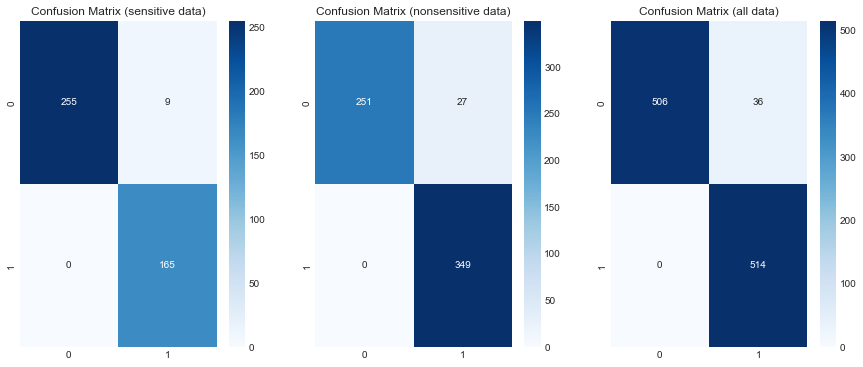

In [57]:
plot_model_performance(pred_PR_test_s, pred_PR_test_n, pred_PR_test, y_PR_test_s, y_PR_test_n, y_PR_test)

#### PR bias metrics

In [58]:
fair_metrics_PR = fair_metrics(pred_PR_test_s, pred_PR_test_n, pred_PR_test, y_PR_test_s, y_PR_test_n, y_PR_test)

### Check bias metrics :

A model can be considered bias if just one of these four metrics show that this model is biased.

#### For the Race attribute :

With default thresholds, bias against unprivileged group detected in **2** out of 4 metrics

,calibration,equal_opportunity_difference,average_abs_odds_difference,disparate_impact
objective,0.000000,0.000000,0.000000,1.000000
Race,0.022083,-0.172003,0.097043,1.023077


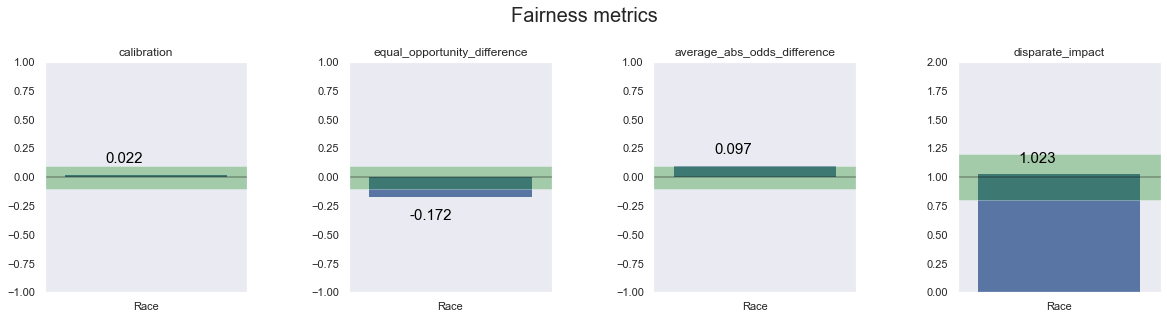

In [59]:
plot_fair_metrics(fair_metrics_PR)
display(fair_metrics_PR)